In [1]:
""" 
Author: maxwell.cook@colorado.edu
"""

import os, sys, gc, time
import geopandas as gpd
import rasterio as rio
import rioxarray as rxr
import seaborn as sns
import matplotlib.pyplot as plt

# Custom functions
sys.path.append(os.path.join(os.getcwd(),'code/'))
from __functions import *

proj = 'EPSG:5070'

maindir = '/Users/max/Library/CloudStorage/OneDrive-Personal/mcook/'
projdir = os.path.join(maindir, 'aspen-fire/Aim2/')

print("Ready to go !")

Ready to go !


In [2]:
# Load the VIIRS active fire detections gridded data

In [3]:
fp = os.path.join(projdir,f'data/spatial/mod/VIIRS/viirs_snpp_jpss1_afd_latlon_aspenfires_pixar_gridstats.gpkg')
grid = gpd.read_file(fp)
grid.columns

Index(['grid_index', 'grid_area', 'afd_count', 'unique_days', 'frp_csum',
       'frp_max', 'frp_min', 'frp_p90', 'frp_first', 'day_max_frp',
       'dt_max_frp', 'first_obs_date', 'last_obs_date', 'day_count',
       'night_count', 'frp_max_day', 'frp_max_night', 'frp_p90_day',
       'frp_p90_night', 'frp_first_day', 'frp_first_night', 'Fire_ID',
       'Fire_Name', 'geometry'],
      dtype='object')

In [4]:
print(f"There are [{len(grid['Fire_ID'].unique())}] fire events in the Southern Rockies (2018-2023)")
print(f"\tWith {len(grid)} gridcells.")

There are [58] fire events in the Southern Rockies (2018-2023)
	With 49047 gridcells.


In [5]:
bounds = grid.total_bounds # for cropping the raster data

# USFS TreeMap (2016) Summaries

From Earth Engine, the forest type percent cover for each gridcell was calculated. From this, we also gathered the "all forest" percent. Then, within a mask for each species, the TreeMap metrics (e.g., BALIVE) were summarized. Finally, within each species mask the Sentinel-2 LAI and MNDWI averages were gathered.

In [6]:
# Load the summary table (from GEE reductions)
fp = os.path.join(projdir,'data/earth-engine/exports/treemap/gridstats_fortypcd.csv')
fortypcd = pd.read_csv(fp)
fortypcd.drop(columns=['system:index','.geo'], inplace=True) # drop the GEE id and .geo columns

# unpack histogram dictionary into columns
def parse_histogram(hist_str):
    # Convert float or NaN to string, then parse
    if isinstance(hist_str, float) or pd.isna(hist_str):
        hist_str = str(int(hist_str)) if not pd.isna(hist_str) else ""
    kv_pairs = hist_str.split(', ')  # Split the key-value pairs
    # Convert key-value pairs to a dictionary
    return {int(kv.split(':')[0]): float(kv.split(':')[1]) for kv in kv_pairs if ':' in kv}

# parse the dictionary
fortypcd['species_histogram'] = fortypcd['species_histogram'].apply(parse_histogram)

hist_df = fortypcd['species_histogram'].apply(pd.Series)
fortypcd = pd.concat([fortypcd.drop(columns=['species_histogram']), hist_df], axis=1).reset_index(drop=True)

del hist_df

print("Adjusted DataFrame:")
fortypcd.head(3)

Adjusted DataFrame:


,grid_index,total_pixels,182,185,221,225,369,371,901,971,...,367,801,995,171,923,263,805,976,507,924
0,919906,196.949020,3.094118,7.000000,41.768627,36.423529,2.674510,11.607843,0.494118,4.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,919907,197.176471,9.227451,NaN,75.027451,32.870588,12.109804,6.827451,NaN,1.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,919908,196.960784,15.611765,10.996078,37.329412,15.466667,12.000000,2.000000,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [7]:
# Pivot longer and join to get species name
fortypcd_l = fortypcd.melt(id_vars=['grid_index','total_pixels'], var_name='FORTYPCD', value_name='count')
fortypcd_l['FORTYPCD'] = fortypcd_l['FORTYPCD'].astype(int)

# Drop 'NaN' counts (species not present in the AFD)
fortypcd_l.dropna(subset=['count'], inplace=True)
fortypcd_l.sort_values(by=['grid_index'], inplace=True)
print("Dropped NA values.")
print(fortypcd_l.columns)

# load the species lookup table
fp = os.path.join(projdir,'data/tabular/mod/treemap_fortypcd_species_mapping.csv')
species_df = pd.read_csv(fp)
species_df = species_df[['FORTYPCD','SpeciesName']]
species_df = species_df[species_df['FORTYPCD'].isin(fortypcd_l['FORTYPCD'].unique())]
print(species_df.columns)

# merge with grid summary to get forest species name
fortypcd_l_ = fortypcd_l.merge(species_df, on='FORTYPCD', how='left')

del fortypcd_l

fortypcd_l_.head(3)

Dropped NA values.
Index(['grid_index', 'total_pixels', 'FORTYPCD', 'count'], dtype='object')
Index(['FORTYPCD', 'SpeciesName'], dtype='object')


,grid_index,total_pixels,FORTYPCD,count,SpeciesName
0,184440,199.756863,185,123.662745,Pinyon / juniper woodland
1,184440,199.756863,184,15.968627,Juniper woodland
2,184441,199.482353,185,114.670588,Pinyon / juniper woodland


In [8]:
# print a unqiue list of tree species
fortypcd_l_['SpeciesName'].unique()

array(['Pinyon / juniper woodland', 'Juniper woodland',
       'Mesquite woodland', 'Other exotic hardwoods', 'Cottonwood',
       'Deciduous oak woodland', 'Rocky Mountain juniper',
       'Ponderosa pine', 'Western juniper', 'Other hardwoods',
       'Sugarberry / hackberry / elm / green ash', 'Nonstocked',
       'Douglas-fir', 'Cottonwood / willow', 'Bur oak',
       'Western redcedar', 'Grand fir', 'Aspen', 'White fir',
       'Cercocarpus (mountain brush) woodland', 'Lodgepole pine',
       'Engelmann spruce', 'Western larch',
       'Intermountain maple woodland', 'Engelmann spruce / subalpine fir',
       'Subalpine fir', 'Blue spruce', 'Limber pine',
       'Foxtail pine / bristlecone pine', 'Balsam fir', 'Paper birch',
       'Miscellaneous western softwoods', 'Noble fir',
       'Sugar maple / beech / yellow birch', 'Hard maple / basswood',
       'California mixed conifer', 'Jeffrey pine',
       'Evergreen oak woodland', 'Eastern redcedar / hardwood',
       'Elm / ash / b

In [9]:
# calculate the total forest count and percent cover for each species
forest_count = fortypcd_l_.groupby('grid_index')['count'].sum().reset_index()
forest_count = forest_count.rename(columns={'count': 'forest_pix'})

# Join back to the data frame, calculate percent cover
fortypcd_l_pct = fortypcd_l_.merge(forest_count, on='grid_index', how='left')
fortypcd_l_pct['spp_pct'] = (fortypcd_l_pct['count'] / fortypcd_l_pct['forest_pix']) * 100
fortypcd_l_pct['forest_pct'] = (fortypcd_l_pct['forest_pix'] / fortypcd_l_pct['total_pixels']) * 100

# reshape the columns
cols = ['grid_index', 'FORTYPCD', 'SpeciesName', 'count', 'forest_pix', 'total_pixels', 'spp_pct', 'forest_pct']
fortypcd_l_pct = fortypcd_l_pct[cols]

# check the results
fortypcd_l_pct = fortypcd_l_pct.sort_values(by=['grid_index'])
print(fortypcd_l_pct.columns)

del fortypcd_l_

fortypcd_l_pct.head(3)

Index(['grid_index', 'FORTYPCD', 'SpeciesName', 'count', 'forest_pix',
       'total_pixels', 'spp_pct', 'forest_pct'],
      dtype='object')


,grid_index,FORTYPCD,SpeciesName,count,forest_pix,total_pixels,spp_pct,forest_pct
0,184440,185,Pinyon / juniper woodland,123.662745,139.631373,199.756863,88.563725,69.900664
1,184440,184,Juniper woodland,15.968627,139.631373,199.756863,11.436275,69.900664
2,184441,185,Pinyon / juniper woodland,114.670588,118.909804,199.482353,96.434932,59.609185


In [10]:
# Create a histogram of the forest species (prevalence)



Species making up 97% of the total: 

                         SpeciesName         count  fraction  c_fraction
27                    Lodgepole pine  2.408028e+06  0.294627    0.294627
40                    Ponderosa pine  1.613215e+06  0.197380    0.492007
0                              Aspen  9.797278e+05  0.119872    0.611878
18  Engelmann spruce / subalpine fir  9.040129e+05  0.110608    0.722486
13                       Douglas-fir  4.746550e+05  0.058075    0.780561
39         Pinyon / juniper woodland  3.094141e+05  0.037857    0.818418
17                  Engelmann spruce  3.032830e+05  0.037107    0.855526
46                     Subalpine fir  2.284919e+05  0.027956    0.883482
21                         Grand fir  1.917080e+05  0.023456    0.906938
53                         White fir  1.721483e+05  0.021063    0.928001
12            Deciduous oak woodland  1.257371e+05  0.015384    0.943385
43            Rocky Mountain juniper  1.201248e+05  0.014697    0.958082
6          

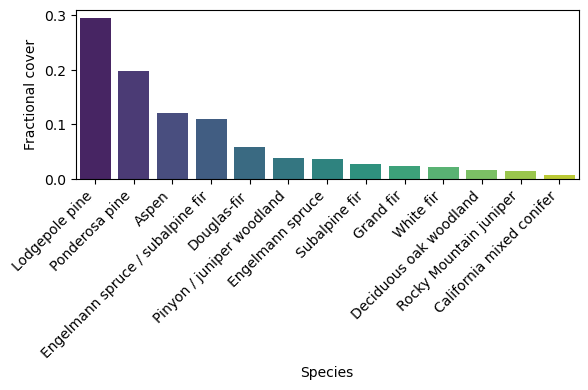

In [27]:
fortyp = fortypcd_l_pct.copy() # make a copy to work with
fortyp = fortyp[fortyp['count'] > 0] # make sure there are some pixels

# calculate the landscape fraction (prevalence)
spp_pr = fortyp.groupby('SpeciesName')['count'].sum().reset_index()
spp_pr['fraction'] = spp_pr['count'] / spp_pr['count'].sum()
spp_pr = spp_pr.sort_values(by='fraction', ascending=False)

# which species make up 97% of observations?
spp_pr['c_fraction'] = spp_pr['fraction'].cumsum()
top_species = spp_pr[spp_pr['c_fraction'] <= 0.97]
print(f"\n\nSpecies making up 97% of the total: \n\n{top_species}\n\n")

# plot it
plt.figure(figsize=(6, 4))
sns.barplot(data=top_species, x='SpeciesName', y='fraction', palette='viridis')
plt.xlabel('Species')
plt.ylabel('Fractional cover')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

In [28]:
fortyp.columns

Index(['grid_index', 'FORTYPCD', 'SpeciesName', 'count', 'forest_pix',
       'total_pixels', 'spp_pct', 'forest_pct'],
      dtype='object')



Species making up 97% of the total: 

               SpeciesName         count  fraction  c_fraction
23          Lodgepole pine  2.408028e+06  0.294627    0.294627
41              Spruce-fir  1.799644e+06  0.220190    0.514817
36          Ponderosa pine  1.613215e+06  0.197380    0.712197
0                    Aspen  9.797278e+05  0.119872    0.832068
35  Pinon-juniper woodland  5.301839e+05  0.064869    0.896937
13             Douglas-fir  4.746550e+05  0.058075    0.955012




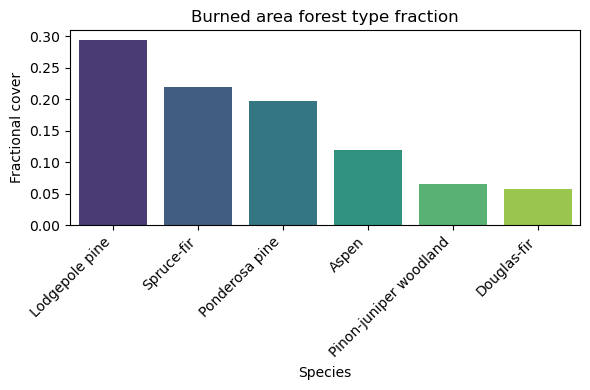

In [29]:
# perform a remap for some forest types
# create a 'Spruce-fir' category
# 'Pinon-juniper woodland' category
spp_remap = {
    'Engelmann spruce': 'Spruce-fir',
    'Subalpine fir': 'Spruce-fir',
    'White fir': 'Spruce-fir',
    'Grand fir': 'Spruce-fir',
    'Engelmann spruce / subalpine fir': 'Spruce-fir',
    'Western juniper': 'Pinon-juniper woodland',
    'Rocky Mountain juniper': 'Pinon-juniper woodland',
    'Pinyon / juniper woodland': 'Pinon-juniper woodland',
    'Juniper woodland': 'Pinon-juniper woodland'
}

# Add a new column for the merged categories
fortyp['SpeciesName'] = fortyp['SpeciesName'].map(spp_remap).fillna(fortyp['SpeciesName'])
# Now handle the new columns (groupby and summarise)
fortyp = fortyp.groupby(['grid_index', 'SpeciesName'], as_index=False).agg({
    'spp_pct': 'sum',
    'forest_pct': 'max',
    'count': 'sum',
    'total_pixels': 'max'
})

# re-plot the dataframe
# Calculate the total percent cover (prevalence)
spp_pr = fortyp.groupby('SpeciesName')['count'].sum().reset_index()
spp_pr['fraction'] = spp_pr['count'] / spp_pr['count'].sum()
spp_pr = spp_pr.sort_values(by='fraction', ascending=False)

# which species make up 97% of observations?
spp_pr['c_fraction'] = spp_pr['fraction'].cumsum()
top_species = spp_pr[spp_pr['c_fraction'] <= 0.97]
print(f"\n\nSpecies making up 97% of the total: \n\n{top_species}\n\n")

# plot it
plt.figure(figsize=(6, 4))
sns.barplot(data=top_species, x='SpeciesName', y='fraction', palette='viridis')
plt.title('Burned area forest type fraction')
plt.xlabel('Species')
plt.ylabel('Fractional cover')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()

plt.savefig(os.path.join(projdir, 'figures/FigureX_FORTYPCD_FractionalCover.png'), dpi=300, bbox_inches='tight')

plt.show()

In [14]:
# join the forest type dataframe to our FRP gridcells

In [30]:
grid_fortyp = grid.merge(fortyp, on='grid_index', how='left')
grid_fortyp.columns

Index(['grid_index', 'grid_area', 'afd_count', 'unique_days', 'frp_csum',
       'frp_max', 'frp_min', 'frp_p90', 'frp_first', 'day_max_frp',
       'dt_max_frp', 'first_obs_date', 'last_obs_date', 'day_count',
       'night_count', 'frp_max_day', 'frp_max_night', 'frp_p90_day',
       'frp_p90_night', 'frp_first_day', 'frp_first_night', 'Fire_ID',
       'Fire_Name', 'geometry', 'SpeciesName', 'spp_pct', 'forest_pct',
       'count', 'total_pixels'],
      dtype='object')

In [37]:
# check for duplicates
print(f"Number of duplicate rows: {grid_fortyp.duplicated(subset=['grid_index', 'SpeciesName', 'spp_pct']).sum()}")
grid_fortyp = grid_fortyp.drop_duplicates(subset=['grid_index', 'SpeciesName', 'spp_pct'])

Number of duplicate rows: 1184


In [38]:
# subset the grids to predominantly forested plots (>50% forested)
grid_forest = grid_fortyp[grid_fortyp['forest_pct'] > 50]
n_forest = len(grid_forest['grid_index'].unique())
print(f"{n_forest}/{len(grid)} [{round(n_forest/len(grid)*100,1)}%] gridcells are forested.")

41955/49047 [85.5%] gridcells are forested.


In [39]:
print(top_species['SpeciesName'].unique()) # check on our top species
# subset columns in our forested gridcells to retain just our top species
grid_forest = grid_forest[grid_forest['SpeciesName'].isin(top_species['SpeciesName'].unique())]
len(grid_forest['grid_index'].unique())

['Lodgepole pine' 'Spruce-fir' 'Ponderosa pine' 'Aspen'
 'Pinon-juniper woodland' 'Douglas-fir']


41955

In [40]:
# save the TreeMap table out.
out_fp = os.path.join(projdir,'data/tabular/mod/viirs_snpp_jpss1_gridstats_fortypcd.csv')
grid_forest.to_csv(out_fp)
print(f"Saved file to: {out_fp}")

Saved file to: /Users/max/Library/CloudStorage/OneDrive-Personal/mcook/aspen-fire/Aim2/data/tabular/mod/viirs_snpp_jpss1_gridstats_fortypcd.csv


In [19]:
# make some plots showing the distribution of FRP across forest types

In [41]:
# first, gather the dominant forest type
dfortyp = grid_forest.loc[grid_forest.groupby('grid_index')['spp_pct'].idxmax()]
print(dfortyp['SpeciesName'].unique())
print("\n")

# drop any 0 FRP gridcells
n_small = len(dfortyp[dfortyp['frp_csum'] < 1]) # very small FRP values (cumulative)
print(f"Dropping {n_small} [{round(n_small/len(dfortyp)*100,1)}%] gridcells w/ <1 cumulative FRP.")
dfortyp = dfortyp[dfortyp['frp_csum'] > 1]

['Pinon-juniper woodland' 'Ponderosa pine' 'Aspen' 'Douglas-fir'
 'Lodgepole pine' 'Spruce-fir']


Dropping 1597 [3.8%] gridcells w/ <1 cumulative FRP.


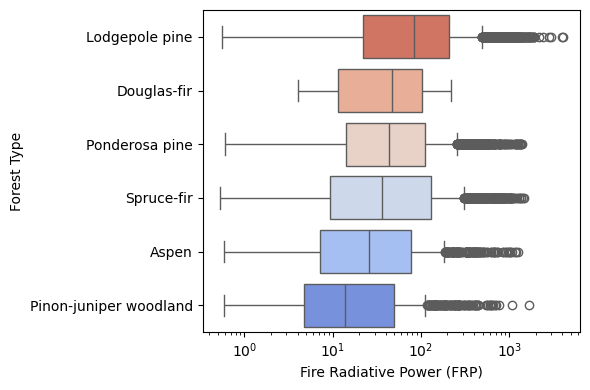


Saved to: /Users/max/Library/CloudStorage/OneDrive-Personal/mcook/aspen-fire/Aim2/figures/FigureX_FORTYPCD_DominantSpecies_FRPmax.png



In [44]:
# Plot FRP by dominant forest type
# Find the median and sort the forest types by FRP
med = dfortyp.groupby('SpeciesName')['frp_max'].median().sort_values(ascending=False)
sorted = med.index.tolist()

# create a dataframe with dominance (>90% of the same species)
dom = dfortyp[dfortyp['spp_pct'] > 80]

# plot it
plt.figure(figsize=(6, 4)) 

sns.boxplot(
    data=dom, 
    x='frp_max', 
    y='SpeciesName', 
    order=sorted, 
    palette='coolwarm_r', 
    dodge=False)

plt.xscale('log') # log-scale FRP
plt.xlabel('Fire Radiative Power (FRP)')
plt.ylabel('Forest Type')
plt.tight_layout()

out_plot = os.path.join(projdir, 'figures/FigureX_FORTYPCD_DominantSpecies_FRPmax.png')
plt.savefig(out_plot, dpi=300, bbox_inches='tight')

plt.show()
print(f"\nSaved to: {out_plot}\n")

In [22]:
# forest type composition effects on FRP

In [45]:
# get aspen grids (any aspen component)
# get gridcells with at least some aspen
aspen_idx = grid_forest[grid_forest['SpeciesName'] == 'Aspen']['grid_index'].unique() # list of grid indices
grid_aspen = grid_forest[grid_forest['grid_index'].isin(aspen_idx)]

# check how many aspen gridcells there are
n_aspen = len(grid_aspen['grid_index'].unique())
print(f"There are a total of {n_aspen} [{round(n_aspen/len(grid_forest['grid_index'].unique())*100,1)}%] gridcells with some aspen component.")

There are a total of 26992 [64.3%] gridcells with some aspen component.


In [46]:
print(f"Number of duplicate rows: {grid_aspen.duplicated(subset=['grid_index', 'SpeciesName']).sum()}")

Number of duplicate rows: 0


In [47]:
# drop any 0 FRP gridcells
n_small = len(grid_aspen[grid_aspen['frp_csum'] < 1]) # very small FRP values (cumulative)
grid_aspen = grid_aspen[grid_aspen['frp_csum'] > 1]
print(f"Dropped {n_small} [{round(n_small/len(grid_aspen)*100,1)}%] gridcells w/ <1 cumulative FRP.")
grid_aspen[['grid_index','SpeciesName','spp_pct','forest_pct','frp_csum','frp_max','afd_count']].head()

Dropped 4491 [3.8%] gridcells w/ <1 cumulative FRP.


,grid_index,SpeciesName,spp_pct,forest_pct,frp_csum,frp_max,afd_count
19,824824,Aspen,79.522855,96.065697,8.942974,8.942974,1
20,824824,Douglas-fir,0.527175,96.065697,8.942974,8.942974,1
22,824824,Pinon-juniper woodland,0.525108,96.065697,8.942974,8.942974,1
23,824824,Ponderosa pine,2.172789,96.065697,8.942974,8.942974,1
24,824824,Spruce-fir,16.387918,96.065697,8.942974,8.942974,1


Associate forest type: ['Douglas-fir', 'Pinon-juniper woodland', 'Ponderosa pine', 'Spruce-fir', 'Lodgepole pine']



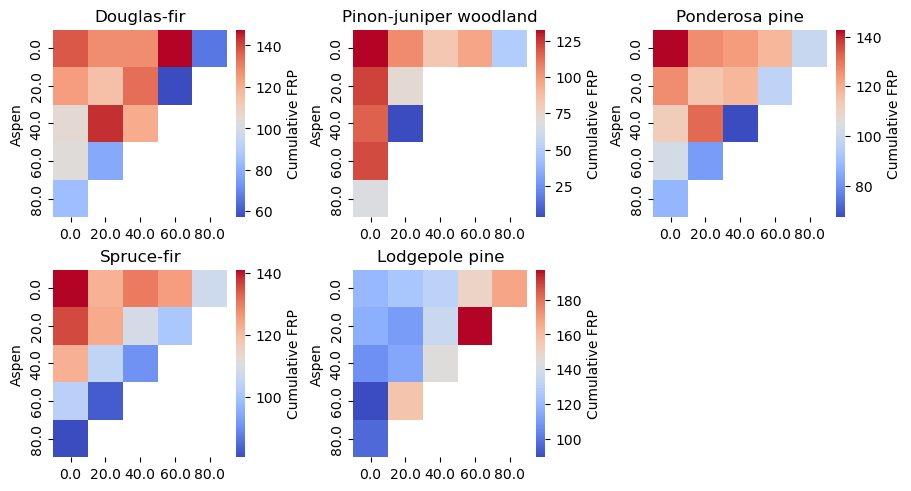

In [143]:
# create bins for species composition
bins = np.linspace(0, 100, 6) # 10% intervals
spps = [s for s in grid_aspen['SpeciesName'].unique() if s != 'Aspen'] # exclude aspen from species list
print(f"Associate forest type: {spps}\n")

df = grid_aspen.copy() # work with a copy

heatmap_das = [] # to store the plotting data
for sp in spps:
    df_sp = df[df['SpeciesName'].isin(['Aspen', sp])]

    # recalculate forest percent based on just these species
    df_sp = df_sp.merge(forest, on='grid_index', how='left')
    # df_sp = df_sp[df_sp['forest_pct_c'] > 10]
    
    # Pivot table to create columns for Aspen and the species
    cover_df = (
        df_sp.pivot_table(index='grid_index', columns='SpeciesName', values='spp_pct', fill_value=0)
        .reset_index()
        .rename(columns={'Aspen': 'aspen_pct', sp: f'{sp}_pct'})
    )
    
    # Merge with FRP data
    frp_df = grid_aspen[['grid_index', 'frp_max', 'frp_csum', 'frp_p90']].drop_duplicates()
    cover_df = cover_df.merge(frp_df, on='grid_index', how='left')

    # Bin the Aspen and species percent cover
    cover_df['aspen_bin'] = pd.cut(cover_df['aspen_pct'], bins, labels=bins[:-1])
    cover_df[f'{sp}_bin'] = pd.cut(cover_df[f'{sp}_pct'], bins, labels=bins[:-1])

    # Group by bins and calculate mean FRP
    heatmap_da = cover_df.groupby(['aspen_bin', f'{sp}_bin'])['frp_max'].mean().unstack()
    heatmap_da = heatmap_da.replace(0, np.nan)
    heatmap_das.append((sp, heatmap_da))

# create the plot
sp_size = 3
n_cols = 3  # Number of columns in the facet grid
n_rows = int(np.ceil(len(heatmap_das) / n_cols))

fig_w = sp_size * n_cols
fig_h = sp_size * 1.6

fig, axes = plt.subplots(n_rows, n_cols, figsize=(fig_w, fig_h), constrained_layout=True)
axes = axes.flatten()

# get the global min/max
vmin = min(hm_da.min().min() for _, hm_da in heatmap_das)
vmax = max(hm_da.max().max() for _, hm_da in heatmap_das)

for i, (sp, hm_da) in enumerate(heatmap_das):
    ax = axes[i]
    sns.heatmap(
        hm_da, cmap='coolwarm', annot=False, fmt=".1f", 
        cbar_kws={'label': 'Cumulative FRP'}, ax=ax,
        square=False
    )
    ax.set_title(f'{sp}')
    ax.set_xlabel('')
    ax.set_ylabel('Aspen')

# Remove unused subplots if species < n_rows * n_cols
for j in range(i + 1, len(axes)):
    fig.delaxes(axes[j])

del df

plt.show()

In [120]:
grid_aspen['forest_pct'].describe()

count    119036.000000
mean         92.269656
std          14.349799
min          50.014171
25%          88.090645
50%          98.293672
75%         100.000000
max         200.000000
Name: forest_pct, dtype: float64

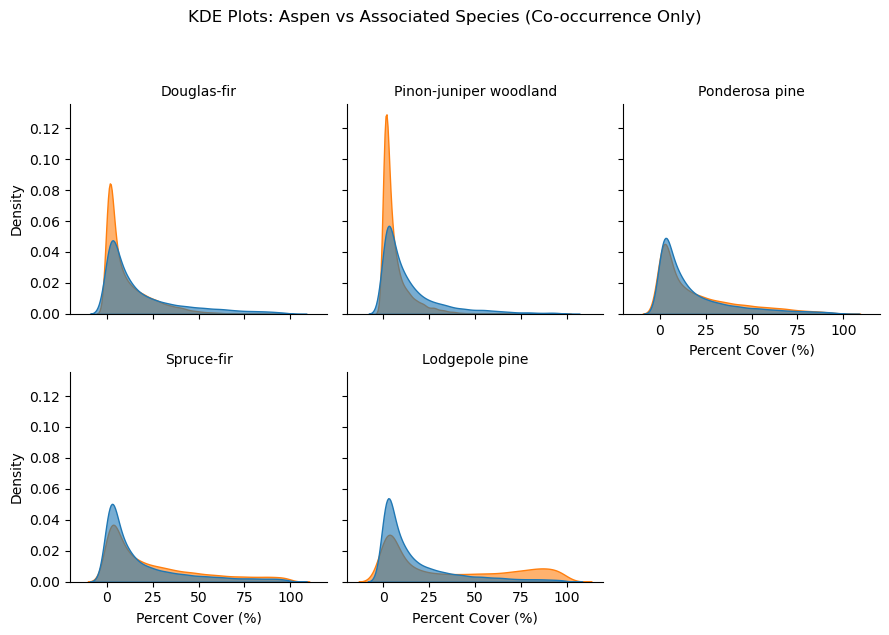

In [123]:
df = grid_aspen.copy() # work with a copy

kde_data = []

# Unique species excluding Aspen
spps = [s for s in df['SpeciesName'].unique() if s != 'Aspen']

# Filter for co-occurrence and prepare data for each species
for sp in spps:
    df_sp = df[df['SpeciesName'].isin(['Aspen', sp])]

    # Pivot table to create columns for Aspen and the species
    cover_df = (
        df_sp.pivot_table(index='grid_index', columns='SpeciesName', values='spp_pct', fill_value=0)
        .reset_index()
        .rename(columns={'Aspen': 'aspen_pct', sp: f'{sp}_pct'})
    )

    # Filter for co-occurrence (both Aspen and the species must have >0 cover)
    cover_df = cover_df[(cover_df['aspen_pct'] > 0) & (cover_df[f'{sp}_pct'] > 0)]

    # Melt data for Seaborn FacetGrid
    melted = cover_df.melt(id_vars='grid_index', value_vars=['aspen_pct', f'{sp}_pct'], 
                           var_name='species', value_name='pct_cover')
    melted['other_spp'] = sp  # Add metadata for faceting
    kde_data.append(melted)

# Combine data for all species
kde_data_df = pd.concat(kde_data, ignore_index=True)

# KDE Facet Plot
g = sns.FacetGrid(kde_data_df, col="other_spp", col_wrap=3, height=3, sharex=True, sharey=True)
g.map_dataframe(sns.kdeplot, x="pct_cover", hue="species", fill=True, alpha=0.6, common_norm=False)

# Adjust labels and titles
g.set_titles("{col_name}")
g.set_axis_labels("Percent Cover (%)", "Density")
plt.suptitle("KDE Plots: Aspen vs Associated Species (Co-occurrence Only)", y=1.05)
plt.tight_layout()
plt.show()

In [56]:
del df, cover_df

In [84]:
grid_forest['forest_pct'].describe()

count    162043.000000
mean         92.811113
std          14.077852
min          50.000000
25%          89.427278
50%          99.022258
75%         100.000000
max         200.000000
Name: forest_pct, dtype: float64

In [99]:
grid_forest['SpeciesName'].unique()

array(['Aspen', 'Douglas-fir', 'Lodgepole pine', 'Ponderosa pine',
       'Spruce-fir', 'Pinon-juniper woodland'], dtype=object)

 Forest classes: ['Aspen' 'Conifer']

count    27080.000000
mean        96.225421
std          7.213427
min          8.678983
25%         95.635301
50%         98.965255
75%        100.000000
max        100.000000
Name: forest_pct, dtype: float64


   grid_index  aspen_pct  conifer_pct     frp_max    frp_csum     frp_p90  \
0      220668   0.508982    90.261477  196.318499  224.195357  179.474335   
1      222930   0.512676    95.586964   24.510062   68.622302   23.296374   
2      222934   0.160396    98.804134  161.180230  243.610102  145.106944   
3      225193   1.548086    84.210318    6.050987   14.319055    3.666826   
4      225194  10.911404    86.862407   16.787122   23.045018   11.167936   

   forest_pct  
0   90.770459  
1   96.099640  
2   98.964530  
3   85.758404  
4   97.773811  




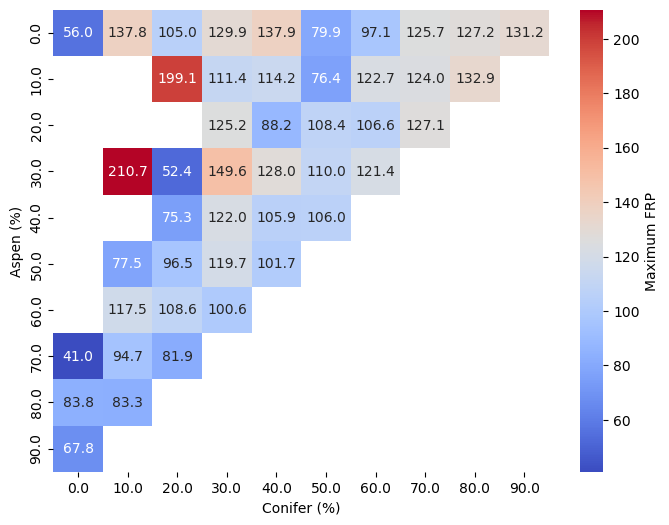

In [112]:
# conifer/aspen
df = grid_forest.copy() # work with a copy

# label conifer/aspen, summarize percent cover
df['ForestPhys'] = df['SpeciesName'].apply(lambda x: 'Conifer' if x != 'Aspen' else x)
print(f" Forest classes: {df['ForestPhys'].unique()}\n")

# Recalculate percent cover
cover_df = (
    df.groupby(['grid_index', 'ForestPhys'])['spp_pct']
    .sum()
    .unstack(fill_value=0)
    .reset_index()
    .rename(columns={'Aspen': 'aspen_pct', 'Conifer': 'conifer_pct'})
)

# make sure there is some aspen 
cover_df = cover_df[(cover_df['aspen_pct'] > 0) & (cover_df['conifer_pct'] > 0)] # make sure is some aspen

# merge back to FRP
cover_df = cover_df.merge(grid[['grid_index','frp_max','frp_csum','frp_p90']], on='grid_index', how='left')

# Calculate the total percent cover
cover_df['forest_pct'] = cover_df['aspen_pct'] + cover_df['conifer_pct']
print(cover_df['forest_pct'].describe()) # make sure none exceed 100
print("\n")
print(cover_df.head())
print("\n")

# # filter based on the 'forest_pct'
# cover_df = cover_df[cover_df['forest_pct'] > 50]
# print(f">50 % combined forested plots: {len(cover_df_)} of {len(cover_df)}\n")

# bin the data and plot the heatmap
bins = np.linspace(0, 100, 11)  # 10% intervals
cover_df['aspen_bin'] = pd.cut(cover_df['aspen_pct'], bins, labels=bins[:-1])
cover_df['conifer_bin'] = pd.cut(cover_df['conifer_pct'], bins, labels=bins[:-1])

# create the summarized data by bins (heatmap)
heatmap_da = cover_df.groupby(['aspen_bin', 'conifer_bin']).frp_max.mean().unstack()
heatmap_da = heatmap_da.replace(0, np.nan)

# heatmap_da_log = np.log10(heatmap_da + 1e-6)

# plot it
plt.figure(figsize=(8, 6))

sns.heatmap(
    heatmap_da, 
    cmap='coolwarm', 
    annot=True, 
    fmt=".1f", 
    cbar_kws={'label': 'Maximum FRP'}
)

plt.xlabel('Conifer (%)')
plt.ylabel('Aspen (%)')
plt.show()

In [ ]:
# confer/aspen
df = aspen_grids.copy()

conifers = ['Spruce-fir', 'Lodgepole pine', 'Ponderosa pine', 'Douglas-fir', 'Pinon-juniper woodland']  # Define conifer species
df['ForestPhys'] = df['SpeciesName'].apply(lambda x: 'Conifer' if x in conifers else x)
print(df['ForestPhys'].unique())

# seperate the aspen/conifer dataframes
conifer_df = df[df['ForestPhys'] == 'Conifer'].groupby('grid_index')['spp_pct'].sum().reset_index()
conifer_df = conifer_df.rename(columns={'spp_pct': 'conifer_pct'})
aspen_df = df[df['ForestPhys'] == 'Aspen'][['grid_index', 'spp_pct']].rename(columns={'spp_pct': 'aspen_pct'})

comp = pd.merge(aspen_df, conifer_df, on='grid_index')
comp = pd.merge(comp, grid[['grid_index','frp_csum','frp_max']], on='grid_index', how='left')
comp = comp[(comp['aspen_pct'] > 0) & (comp['conifer_pct'] > 0)] # ensure some percentage of each

# bin the data and plot
bins = np.linspace(0, 100, 11)  # 10% intervals
comp['Aspen_bin'] = pd.cut(comp['aspen_pct'], bins, labels=bins[:-1])
comp['Conifer_bin'] = pd.cut(comp['conifer_pct'], bins, labels=bins[:-1])

# calculate the average FRP max
heatmap_da = comp.groupby(['Aspen_bin', 'Conifer_bin']).frp_max.mean().unstack()

plt.figure(figsize=(8, 6))

sns.heatmap(
    heatmap_data, 
    cmap='coolwarm', 
    annot=True, 
    fmt=".1f", 
    cbar_kws={'label': 'Mean Cumulative FRP'}
)

plt.xlabel('Conifer Fractional Cover (Binned)')
plt.ylabel('Aspen Fractional Cover (Binned)')
plt.show()

In [ ]:
# merge back with FRP data
df = pd.merge(grid, df, on='grid_index')
df.columns

In [ ]:

# Step 2: Define bins and prepare species list
bins = np.linspace(0, 100, 11)  # Binning from 0 to 100 in 10% intervals
species_list = [s for s in filtered_data['SpeciesName'].unique() if s != 'Aspen']  # Exclude Aspen

# Step 3: Prepare data for facet plotting
heatmap_data_list = []

for species in species_list:
    # Extract Aspen and the current species for the same grid cells
    aspen_data = filtered_data[filtered_data['SpeciesName'] == 'Aspen'][['grid_index', 'spp_pct']]
    species_data = filtered_data[filtered_data['SpeciesName'] == species][['grid_index', 'spp_pct', 'frp_csum']]
    
    # Merge the two datasets on grid_index
    merged = pd.merge(aspen_data, species_data, on='grid_index', suffixes=('_Aspen', f'_{species}'))
    
    # Bin Aspen and the current species
    merged['Aspen_bin'] = pd.cut(merged['spp_pct_Aspen'], bins, labels=bins[:-1])
    merged[f'{species}_bin'] = pd.cut(merged[f'spp_pct_{species}'], bins, labels=bins[:-1])
    
    # Aggregate to calculate mean FRP for each bin combination
    heatmap_data = merged.groupby(['Aspen_bin', f'{species}_bin']).frp_csum.mean().unstack()
    
    # Store the heatmap data for plotting
    heatmap_data_list.append((species, heatmap_data))

# Step 4: Create facet plot
n_species = len(species_list)
n_cols = 3  # Number of columns in the facet grid
n_rows = int(np.ceil(n_species / n_cols))

fig, axes = plt.subplots(n_rows, n_cols, figsize=(15, 5 * n_rows), constrained_layout=True)

# Flatten axes for easy indexing
axes = axes.flatten()

for i, (species, heatmap_data) in enumerate(heatmap_data_list):
    ax = axes[i]
    sns.heatmap(
        heatmap_data, 
        cmap='viridis', 
        annot=False, 
        fmt=".1f", 
        cbar_kws={'label': 'Mean Cumulative FRP'}, 
        ax=ax
    )
    ax.set_title(f'{species} vs Aspen')
    ax.set_xlabel(f'{species} Fractional Cover (Binned)')
    ax.set_ylabel('Aspen Fractional Cover (Binned)')

# Remove unused subplots if species < n_rows * n_cols
for j in range(i + 1, len(axes)):
    fig.delaxes(axes[j])

plt.suptitle('Heatmaps of Aspen and Other Species Fractional Covers vs FRP', fontsize=16, y=1.02)
plt.show()

In [ ]:
# Load the treemap metrics, apply the same remapping

In [ ]:
ftyp_met = os.path.join(projdir,'earth-engine/exports/treemap/gridstats_fortypcd_metrics.csv')
tm_stats = pd.read_csv(ftyp_met)
tm_stats.drop(columns=['system:index','.geo'], inplace=True)
tm_stats.columns

In [ ]:
# unpack histogram dictionary into columns
def parse_histogram(hist_str):
    # Convert float or NaN to string, then parse
    if isinstance(hist_str, float) or pd.isna(hist_str):
        hist_str = str(int(hist_str)) if not pd.isna(hist_str) else ""
    kv_pairs = hist_str.split(', ')  # Split the key-value pairs
    # Convert key-value pairs to a dictionary
    return {kv.split(':')[0]: float(kv.split(':')[1]) for kv in kv_pairs if ':' in kv}

# parse the dictionary
tm_stats['species_metrics'] = tm_stats['species_metrics'].apply(parse_histogram)
hist_df = tm_stats['species_metrics'].apply(pd.Series)
tm_stats = pd.concat([tm_stats.drop(columns=['species_metrics']), hist_df], axis=1).reset_index(drop=True)
print("Adjusted DataFrame:")
tm_stats.head(3)

In [ ]:
# isolate melt bands/columns
band_names = ['BALIVE', 'SDIPCT_RMRS', 'STANDHT', 'TPA_DEAD', 'TPA_LIVE']
regex_p = '|'.join(band_names) # regex pattern for melting columns
metrics_cols = [col for col in tm_stats.columns if '_mn' in col]
print(f"[{len(metrics_cols)}] total metrics columns selected for melting:\n")

# do the melt
tm_stats_l = tm_stats.melt(
    id_vars=['grid_index'], 
    value_vars=metrics_cols, 
    var_name='metric', 
    value_name='value'
)
tm_stats_l.head(3)

In [ ]:
# gather the forest type code from the band name
tm_stats_l['FORTYPCD'] = tm_stats_l['metric'].str.extract(r'^(\d+)_')[0].astype(int)
tm_stats_l['metric'] = tm_stats_l['metric'].str.extract(f'({regex_p})')[0]
tm_stats_l = tm_stats_l[['grid_index','FORTYPCD','metric','value']]
tm_stats_l.dropna(subset=['value'], inplace=True) # drop NaNs
tm_stats_l['metric'].unique()

In [ ]:
# pivot longer to get metrics as columns
tm_stats_lp = tm_stats_l.pivot_table(index=['grid_index', 'FORTYPCD'], columns='metric', values='value')
tm_stats_lp = tm_stats_lp.reset_index() # collapse the index
tm_stats_lp = tm_stats_lp[['grid_index','FORTYPCD']+band_names]
tm_stats_lp.rename(columns={'SDIPCT_RMRS': 'SDIPCT'}, inplace=True)
tm_stats_lp.head(3)

In [ ]:
# load the Sentinel-2 metrics

In [ ]:
fp = os.path.join(projdir,'earth-engine/exports/treemap/gridstats_fortypcd_s2.csv')
s2_stats = pd.read_csv(fp)
s2_stats.drop(columns=['system:index','.geo'], inplace=True)
s2_stats.columns

In [ ]:
# unpack histogram dictionary into columns
def parse_histogram(hist_str):
    # Convert float or NaN to string, then parse
    if isinstance(hist_str, float) or pd.isna(hist_str):
        hist_str = str(int(hist_str)) if not pd.isna(hist_str) else ""
    kv_pairs = hist_str.split(', ')  # Split the key-value pairs
    # Convert key-value pairs to a dictionary
    return {kv.split(':')[0]: float(kv.split(':')[1]) for kv in kv_pairs if ':' in kv}
# parse the dictionary
s2_stats['species_s2'] = s2_stats['species_s2'].apply(parse_histogram)
s2_stats.head(3)

In [ ]:
hist_df = s2_stats['species_s2'].apply(pd.Series)
s2_stats = pd.concat([s2_stats.drop(columns=['species_s2']), hist_df], axis=1).reset_index(drop=True)
print("Adjusted DataFrame:")
s2_stats.head(3)

In [ ]:
# extract the correct band names / columns
band_names = ['LAI', 'MNDWI']
regex_p = '|'.join(band_names) # regex pattern for melting columns
metrics_cols = [col for col in s2_stats.columns if 'LAI' or 'MNDWI' in col]
print(f"[{len(metrics_cols)}] total metrics columns selected for melting:\n")
# do the melt
s2_stats_l = s2_stats.melt(
    id_vars=['grid_index'], 
    value_vars=metrics_cols, 
    var_name='metric', 
    value_name='value'
)
s2_stats_l.head(3)

In [ ]:
# gather the forest type code
s2_stats_l['FORTYPCD'] = s2_stats_l['metric'].str.extract(r'^(\d+)_')[0].astype(int)
s2_stats_l['metric'] = s2_stats_l['metric'].str.extract(f'({regex_p})')[0]
s2_stats_l = s2_stats_l[['grid_index','FORTYPCD','metric','value']]
s2_stats_l.dropna(subset=['value'], inplace=True) # drop NaNs
s2_stats_l['metric'].unique()

In [ ]:
# pivot longer the get metrics as columns
s2_stats_lp = s2_stats_l.pivot_table(index=['grid_index', 'FORTYPCD'], columns='metric', values='value')
s2_stats_lp = s2_stats_lp.reset_index() # collapse the index
s2_stats_lp = s2_stats_lp[['grid_index','FORTYPCD','LAI','MNDWI']]
s2_stats_lp.head(3)

In [ ]:
# Merge the TreeMap metrics with the Sentinel-2 metrics
# Merge to the FRP grid

In [ ]:
# Join to the FORTYPCD dataframe by grid index and FORTYPCD
treemap_df = fortyp_df.merge(tm_stats_lp, on=['grid_index','FORTYPCD'], how='left')
treemap_df = treemap_df.merge(s2_stats_lp, on=['grid_index','FORTYPCD'], how='left')

# Make sure we're just keeping our 97% landscape fraction forest types
treemap_df = treemap_df[treemap_df['SpeciesName'].isin(top_species['SpeciesName'].unique())]

print(treemap_df.columns)
treemap_df['SpeciesName'].unique()

In [ ]:
treemap_df.head(3)

In [ ]:
# save the TreeMap table out.
out_fp = os.path.join(projdir,'tabular/mod/viirs_snpp_jpss1_gridstats_treemap-s2.csv')
treemap_df.to_csv(out_fp)
print(f"Saved file to: {out_fp}")

In [ ]:
# Identify the dominant forest type for each gridcell
# Subset to forested gridcells (>50%)

In [ ]:
grid_dtree = grid_forest.loc[grid_forest.groupby('grid_index')['spp_pct'].idxmax()]
print(grid_dtree['SpeciesName'].unique())

In [ ]:
# plot the distribution of FRP max and cumulative
print(f"Maximum FRP distribution:\n {grid_dtree['frp_max'].describe()}\n")
print(f"Cumulative FRP distribution:\n {grid_dtree['frp_csum'].describe()}\n")

In [ ]:
# Plot FRP by EVT group name
# Find the median and sort the evt classes
med = grid_dtree.groupby('SpeciesName')['frp_csum'].median().sort_values(ascending=False)
sorted = med.index.tolist()

grid_dtree['frp_max_adj'] = grid_dtree['frp_max'] + 1
grid_dtree['frp_csum_adj'] = grid_dtree['frp_csum'] + 1

# create a dataframe with dominance (>90% of the same species)
dom = grid_dtree[grid_dtree['spp_pct'] > 80]

# plot it
plt.figure(figsize=(6, 4)) 

sns.boxplot(
    data=dom, 
    x='frp_max_adj', 
    y='SpeciesName', 
    order=sorted, 
    palette='coolwarm_r', 
    dodge=False)

plt.xscale('log')

plt.xlabel('Fire Radiative Power (FRP)')
plt.ylabel('Forest Type')

plt.tight_layout()

plt.savefig(os.path.join(projdir, 'figures/FigureX_FORTYPCD_DominantSpecies_FRPcsum.png'), dpi=300, bbox_inches='tight')

plt.show()

In [ ]:
# plot total detections by forest type

In [ ]:
total_afd = grid_dtree['afd_count'].sum() # total afd counts
# proportional counts
afd_props = (
    grid_dtree.groupby('SpeciesName')['afd_count']
    .sum()
    .reset_index(name='afd_count')
)
afd_props['afd_prop'] = afd_props['afd_count'] / total_afd
# merge with the species prevalence
afd_props_spp = pd.merge(afd_props, spp_prevalence, on='SpeciesName', how='inner')
afd_props_spp.head(7)

In [ ]:
# plot the difference between landscape fraction and afd
plt.figure(figsize=(6, 4.25))
sns.barplot(
    data=afd_props_spp.melt(
        id_vars='SpeciesName',
        value_vars=['afd_prop', 'fraction'],
        var_name='Proportion Type',
        value_name='Proportion'
    ),
    x='SpeciesName',
    y='Proportion',
    hue='Proportion Type',
    palette='viridis'
)

plt.title('Proportion of Fire Detections vs. Landscape Proportion by Species')
plt.xlabel('Dominant Tree Species')
plt.ylabel('Proportion')
plt.xticks(rotation=45, ha='right')
plt.legend(title='Proportion Type')
plt.tight_layout()

plt.savefig(os.path.join(projdir, 'figures/FigureX_FORTYPCD_FractionalCover_Detections.png'), dpi=300, bbox_inches='tight')

plt.show()

In [ ]:
grid_dtree.columns

In [ ]:
grid_dtree_ = grid_dtree.merge(tm_stats_lp, on='grid_index', how='inner')
grid_dtree_.columns

In [ ]:
# plot the relationship between BALIVE and FRP by species
g = sns.lmplot(
    data=grid_dtree_, x='frp_max', y='BALIVE', hue='SpeciesName', col='SpeciesName', 
    col_wrap=3, height=2, aspect=1.2, scatter_kws={'alpha':0.4}, line_kws={'color':'black'}, 
    sharey=True, palette='viridis'
)

for ax in g.axes.flat:
    ax.set_ylim(0, grid_dtree_['BALIVE'].max()+0.2)  # Set the y-axis limit from 0 to 4
    ax.set_title(ax.get_title().replace('SpeciesName = ', ''))

plt.savefig(os.path.join(projdir,'figures/FigureX_FORTYPCD_FRP_BALIVE.png'), dpi=300, bbox_inches='tight')

plt.show()

In [ ]:
import matplotlib.colors as mcolors
import matplotlib.cm as cm

In [ ]:
# plot FRP by species quantiles

grid_forest['frp_max_adj'] = grid_forest['frp_max'] + 1

quantiles = 5
grid_forest['spp_pct_qt'] = grid_forest.groupby('SpeciesName')['spp_pct'].transform(
    lambda x: pd.qcut(x, q=quantiles, labels=False) + 1
)
unique_species = grid_forest['SpeciesName'].unique()
species_colors = sns.color_palette('tab20', len(unique_species))  # Assign unique color per species
quantile_shades = {
    species: [mcolors.to_hex(cm.viridis(i / (quantiles - 1))) for i in range(quantiles)]
    for species in unique_species
}
grid_forest['quantile_color'] = grid_forest.apply(
    lambda row: quantile_shades[row['SpeciesName']][row['spp_pct_qt'] - 1],
    axis=1
)

plt.figure(figsize=(12, 6))

# Sort species by median FRP for better organization
med_frp = grid_forest.groupby('SpeciesName')['frp_max_adj'].median().sort_values(ascending=False)
sorted_species = med_frp.index.tolist()

sns.boxplot(
    data=grid_forest,
    x='SpeciesName',
    y='frp_max_adj',
    hue='spp_pct_qt',
    order=sorted_species,
    palette='viridis',
    dodge=True
)

# Customize legend
handles, labels = plt.gca().get_legend_handles_labels()
plt.legend(handles, [f"Quantile {int(label)+1}" for label in labels], title="Species % Cover Quantile", bbox_to_anchor=(1.05, 1), loc='upper left')

# Set log scale for FRP
plt.yscale('log')

# Add labels and title
plt.xlabel('Forest Type', fontsize=12)
plt.ylabel('Fire Radiative Power (FRP)', fontsize=12)
plt.title('Distribution of FRP by Species % Cover Quantiles', fontsize=14)

plt.tight_layout()
plt.savefig(os.path.join(projdir, 'figures/FigureX_FRP_Species_Quantiles.png'), dpi=300, bbox_inches='tight')
plt.show()